In [7]:
CONFIG_PATH = "configs/small_sample_sub_no_peer.yml"

In [8]:
from collections import Counter, defaultdict
import os
import random
import shutil
import numpy as np
import pandas as pd
from superdebug import debug
import torch
from process_data import get_model_input
from utils import get_config, join_sets, load_model, print_log, save_model, load_model_dict
from model import get_best_model
from venn import venn, pseudovenn

##### Preprocess

Load model and data

In [16]:
config = get_config(CONFIG_PATH, "_curation", print_config = False)
target, original_feature_map, categorical_features, string_features, train_data, test_data, test_data_info, num_all_users = get_model_input(config)
extra_input = (categorical_features, string_features, target)
model, token_embedding = get_best_model(config, categorical_features, string_features, original_feature_map)
active_user_votes_thres = config["active_user_votes_thres"]

GPU ready...
Smart using cuda:3
------------------ 2022-08-01 09:00:04 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/process_data.py:327 get_model_input
Loading prepared data...
------------------ 2022-08-01 09:00:04 ------------------
------------------ 2022-08-01 09:00:04 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:239 get_tokenizer
Initializing the tokenizer from sbert-base-uncased
------------------ 2022-08-01 09:00:04 ------------------
------------------ 2022-08-01 09:00:05 ------------------
DEBUG: 1 vars: ['original_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:242 get_tokenizer
0 / 7.  original_token_num num val: 30522
------------------ 2022-08-01 09:00:05 ------------------
------------------ 2022-08-01 09:00:05 ------------------
DEBUG: 1 vars: ['latest_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:254 get_tokenizer
0 / 8.  lates

Collect submissions and active users in different subreddits

In [12]:
def get_subreddits_submissions(train_data:pd.DataFrame, test_data:pd.DataFrame, user_votes_thres = 0):
    subreddit_votes_counter = Counter()
    subreddit_active_users = defaultdict(Counter)
    subreddit_train_submissions = defaultdict(dict)
    subreddit_test_submissions = defaultdict(dict)
    all_submissions = dict()
    for i, row in train_data.iterrows():
        subreddit_votes_counter[row["SUBREDDIT"]] += 1
        subreddit_active_users[row["SUBREDDIT"]][row["USERNAME"]] += 1
        if row["SUBMISSION_ID"] not in subreddit_train_submissions[row["SUBREDDIT"]]:
            subreddit_train_submissions[row["SUBREDDIT"]][row["SUBMISSION_ID"]] = row
            all_submissions[row["SUBMISSION_ID"]] = row
    for subreddit in subreddit_active_users:
        users_vote_count = subreddit_active_users[subreddit]
        subreddit_active_users[subreddit] = {user for user in users_vote_count if users_vote_count[user] >= user_votes_thres}
    for i, row in test_data.iterrows():
        if row["SUBMISSION_ID"] not in subreddit_test_submissions[row["SUBREDDIT"]]:
            subreddit_test_submissions[row["SUBREDDIT"]][row["SUBMISSION_ID"]] = row
            all_submissions[row["SUBMISSION_ID"]] = row
    return subreddit_votes_counter, subreddit_active_users, subreddit_train_submissions, subreddit_test_submissions, all_submissions
subreddit_votes_counter, subreddit_active_users, subreddit_train_submissions, subreddit_test_submissions, all_submissions = get_subreddits_submissions(train_data, test_data, user_votes_thres = active_user_votes_thres) # subreddit_votes_counter, subreddit_users, subreddit_train_submissions are based on train_data, subreddit_test_submissions are based on test_data

Record down existing votes

So that we can use them to substitute the predicted votes

In [13]:
def record_existing_votes(train_data:pd.DataFrame):
    # collect existing votes
    existing_votes = {}
    existing_user_updown_votes = defaultdict(Counter)
    existing_user_votes = Counter()
    existing_submission_votes = defaultdict(Counter)
    for row_i, row in train_data.iterrows():
        existing_votes[f'{row["USERNAME"]}-{row["SUBMISSION_ID"]}'] = row["VOTE"]
        existing_user_updown_votes[row["USERNAME"]][row["VOTE"]] += 1
        existing_user_votes[row["USERNAME"]] += 1
        existing_submission_votes[row["SUBMISSION_ID"]][row["VOTE"]] += 1
    return existing_votes, existing_user_votes, existing_user_updown_votes, existing_submission_votes
existing_votes, existing_user_votes, existing_user_updown_votes, existing_submission_votes = record_existing_votes(train_data)


#### Predict votes for all the users on all submissions

_!!! This process can be time consuming & need more than 200G memory for medium sized dataset, and is not necessary if we use user_embedding to cluster active users_

First convert data to model input

In [14]:
from typing import Union

from tqdm import tqdm
from train import evaluate_model
from model import get_tokenizer

def convert_group_users_subreddit_submissions_data(group_users:Union[set,list], unique_submissions:dict):
    group_users_submissions_data = []
    if type(unique_submissions) == dict:
        unique_submissions = pd.DataFrame(list(unique_submissions.values()))

    for user in tqdm(group_users):
        # for submission_id in unique_submissions:
        #     submission:pd.DataFrame = unique_submissions[submission_id].copy(deep=True)
        #     submission["USERNAME"] = user
        #     group_users_submissions_data.append(submission)
        submissions = unique_submissions.copy(deep=True)
        submissions["USERNAME"] = [user] * len(submissions)
        group_users_submissions_data.append(submissions)

    group_users_submissions_data = pd.concat(group_users_submissions_data,axis=0)
    return group_users_submissions_data
max_username = max(max(train_data["USERNAME"]), max(test_data["USERNAME"]))
all_users = list(range(max_username + 1))
all_users_submissions_data = convert_group_users_subreddit_submissions_data(all_users, all_submissions)


100%|██████████| 21364/21364 [00:10<00:00, 2125.41it/s]


Run model to make predictions.

In [18]:
model.to(model.device)
def predict_group_users_submissions_votes(model, group_users_submissions_data):
    # predict unseen votes
    return evaluate_model(config, model, data=group_users_submissions_data, weights = None, batch_size=config["batch_size"], sample_voted_users=False, extra_input = extra_input, return_prediction = True) # ndarray size: (3423664, 1)

predicted_all_users_submissions_votes = predict_group_users_submissions_votes(model, all_users_submissions_data)
debug(predicted_all_users_submissions_votes=predicted_all_users_submissions_votes)


100%|██████████| 14542/14542 [12:02<00:00, 20.13it/s]


------------------ 2022-08-01 09:12:50 ------------------
DEBUG: 1 vars: ['predicted_all_users_submissions_votes'], at <ipython-input-18-84ea59833998>:7 <module>
0 / 9.  predicted_all_users_submissions_votes ndarray size: (14890708, 1) val: [[0.83064836]
 [0.99098259]
 [0.97458208]
 ...
 [0.07421567]
 [0.06805612]
 [0.0690349 ]]
------------------ 2022-08-01 09:12:50 ------------------


In [ ]:
import pickle
pickle.dump(predicted_all_users_submissions_votes, open("output/predicted_all_users_submissions_votes.pt", "wb"))
# predicted_all_users_submissions_votes = pickle.load(open("output/predicted_all_users_submissions_votes.pt", "rb"))


In [20]:
# model.device = "cuda:0"
def get_group_users_preferred_submissions(model, predicted_group_users_submissions_votes:np.ndarray, group_users, group_users_submissions_data:pd.DataFrame, train_data:pd.DataFrame, existing_votes, thres = 0.9, existing_pred_submission_user_vote_score_matrix = None):
    debug(max_sub_id = max(group_users_submissions_data["SUBMISSION_ID"]), max_username = max(group_users))
    if existing_pred_submission_user_vote_score_matrix is not None:
        pred_submission_user_vote_score_matrix = existing_pred_submission_user_vote_score_matrix
    else:
        pred_submission_user_vote_score_matrix = - np.ones([max(group_users) + 1, max(group_users_submissions_data["SUBMISSION_ID"]) + 1], dtype = float)
    pred_submission_user_vote_matrix = - np.ones([max(group_users) + 1, max(group_users_submissions_data["SUBMISSION_ID"]) + 1], dtype = int) # use ground truth vote if available, -1 for not in data
    each_submission_votes = {}
    each_user_confidence = defaultdict(list)
    submission_ids = group_users_submissions_data["SUBMISSION_ID"].to_numpy()
    usernames = group_users_submissions_data["USERNAME"].to_numpy()
    for row_i in tqdm(range(len(group_users_submissions_data))):
        submission_id = submission_ids[row_i]
        username = usernames[row_i]
        if existing_pred_submission_user_vote_score_matrix is not None:
            vote_score = existing_pred_submission_user_vote_score_matrix[username, submission_id]
        else:
            vote_score = predicted_group_users_submissions_votes[row_i, 0]
            pred_submission_user_vote_score_matrix[username, submission_id] = vote_score
        if submission_id not in each_submission_votes:
            each_submission_votes[submission_id] = [0, 0]
        each_user_confidence[username].append(abs(vote_score - 0.5))
        if f'{username}-{submission_id}' not in existing_votes:
            vote = int(vote_score >= 0.5)
        else: # use existing votes if available
            vote = existing_votes[f'{username}-{submission_id}']
        pred_submission_user_vote_matrix[username, submission_id] = vote
        each_submission_votes[submission_id][vote] += 1

    # analyze user confidence
    for username in each_user_confidence:
        each_user_confidence[username] = float(np.mean(each_user_confidence[username]))

    # include submissions to preferred_submissions where %upvotes is higher than threshold
    group_preferred_submissions = set()
    for submission_id in each_submission_votes:
        each_submission_votes[submission_id].append(each_submission_votes[submission_id][1] / (each_submission_votes[submission_id][0] + each_submission_votes[submission_id][1])) # %upvotes
        if each_submission_votes[submission_id][-1] >= thres:
            group_preferred_submissions.add(submission_id)

    # sort submissions using %upvotes
    group_submissions_ranking = list(each_submission_votes.keys())
    group_submissions_ranking.sort(reverse=True, key=lambda id: each_submission_votes[id][-1])
    return group_preferred_submissions, group_submissions_ranking, each_submission_votes, each_user_confidence, pred_submission_user_vote_score_matrix, pred_submission_user_vote_matrix

Get prediction score matrix and vote matrix.

We use actual votes to replace predicted votes when available

In [21]:
all_users_preferred_submissions, all_preferred_submissions_ranking, all_submission_votes, all_users_confidence, pred_all_submission_user_vote_score_matrix, pred_all_submission_user_vote_matrix = get_group_users_preferred_submissions(model, predicted_all_users_submissions_votes, all_users, all_users_submissions_data, train_data, existing_votes, thres = config["upvote_downvote_ratio_thres"])


------------------ 2022-08-01 09:14:41 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 10.  max_sub_id num val: 696
1 / 11.  max_username num val: 21363
------------------ 2022-08-01 09:14:41 ------------------


100%|██████████| 14890708/14890708 [00:44<00:00, 333971.68it/s]


Calculate Pearson correlation between users

In [22]:
debug((pred_all_submission_user_vote_matrix==-1).any())
debug(pred_all_submission_user_vote_score_matrix=pred_all_submission_user_vote_score_matrix, pred_all_submission_user_vote_matrix=pred_all_submission_user_vote_matrix)
vote_score_pearson_corr = np.corrcoef(pred_all_submission_user_vote_score_matrix) # (697, 697)
debug(vote_score_pearson_corr=vote_score_pearson_corr)

------------------ 2022-08-01 09:15:33 ------------------
DEBUG: 1 vars: ['?'], at <ipython-input-22-1981fee88399>:1 <module>
0 / 12.  ? numpy.bool_ with val:  False
------------------ 2022-08-01 09:15:33 ------------------
------------------ 2022-08-01 09:15:33 ------------------
DEBUG: 2 vars: ['pred_all_submission_user_vote_score_matrix', 'pred_all_submission_user_vote_matrix'], at <ipython-input-22-1981fee88399>:2 <module>
0 / 13.  pred_all_submission_user_vote_score_matrix ndarray size: (21364, 697) val: [[0.45956928 0.98877317 0.93096149 ... 0.98191148 0.98756951 0.99354517]
 [0.00211777 0.09170436 0.01183194 ... 0.05042478 0.0737794  0.20661458]
 [0.12724268 0.97054088 0.74610621 ... 0.94489491 0.9657774  0.98576283]
 ...
 [0.02396497 0.78031093 0.23468372 ... 0.65130347 0.74127489 0.89445138]
 [0.11599034 0.97097009 0.74321872 ... 0.94290709 0.96481174 0.98612088]
 [0.00407325 0.17725961 0.0248001  ... 0.10472968 0.14752102 0.34384057]]
1 / 14.  pred_all_submission_user_vote_ma

#### Perform curation on a subreddit

Select a subreddit from the most popular subreddits

In [23]:
common_subreddits_counts = subreddit_votes_counter.most_common(20)
for subreddit_id, vote_counts in common_subreddits_counts:
    print(f"Subreddit {subreddit_id}: {original_feature_map['SUBREDDIT'][subreddit_id]}, {vote_counts} votes")
a_subreddit = int(input("Select a subreddit: ")) # common_subreddits_counts[0][0]
print_log(config["log_path"], f"Selected subreddit: {a_subreddit} ({original_feature_map['SUBREDDIT'][a_subreddit]})")
a_subreddit_active_users:set = subreddit_active_users[a_subreddit]
print_log(config["log_path"], f"In train data, subreddit {a_subreddit} have {len(a_subreddit_active_users)} active users (who votes >= {active_user_votes_thres} times), {subreddit_votes_counter[a_subreddit]} votes and {len(subreddit_train_submissions[a_subreddit])} unique submissions. In test data, subreddit {a_subreddit} have {len(subreddit_test_submissions[a_subreddit])} unique submissions.") 

Subreddit 67: r/pics, 30485 votes
Subreddit 84: r/worldnews, 28910 votes
Subreddit 69: r/politics, 27319 votes
Subreddit 60: r/news, 10627 votes
Subreddit 50: r/funny, 9629 votes
Subreddit 79: r/todayilearned, 7099 votes
Subreddit 52: r/gifs, 5375 votes
Subreddit 82: r/videos, 4631 votes
Subreddit 1: r/AskReddit, 4050 votes
Subreddit 43: r/aww, 3406 votes
Subreddit 51: r/gaming, 3246 votes
Subreddit 58: r/movies, 2832 votes
Subreddit 33: r/Showerthoughts, 2622 votes
Subreddit 30: r/PublicFreakout, 2122 votes
Subreddit 15: r/HongKong, 1783 votes
Subreddit 74: r/technology, 1611 votes
Subreddit 31: r/SandersForPresident, 1553 votes
Subreddit 40: r/WhitePeopleTwitter, 1463 votes
Subreddit 19: r/IsTodayFridayThe13th, 1329 votes
Subreddit 11: r/Futurology, 1291 votes
------------------ 2022-08-01 09:16:25 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Selected subreddit: 69 (r/politics)
------------------ 2022-08-01 09:16:25 --------

In [24]:
user_grouping_method = config["user_grouping_method"]
# user_grouping_method = "neural"
manual_user_groups = config["manual_user_groups"]
# manual_user_groups = {"Conservative": {66, 39, 10, 44, 16, 60}, "Democratic":{0, 65, 64, 37, 49, 52, 20, 22, 23, 26, 29}}
debug(user_grouping_method=user_grouping_method)


------------------ 2022-08-01 09:16:30 ------------------
DEBUG: 1 vars: ['user_grouping_method'], at <ipython-input-24-27c6d0d6f711>:5 <module>
0 / 16.  user_grouping_method str len 6: neural
------------------ 2022-08-01 09:16:30 ------------------


In [25]:
def get_bool_vec(selected_ids, vec_size):
    bool_vec = torch.zeros([vec_size], dtype = bool)
    for user in selected_ids:
        bool_vec[user] = True
    return bool_vec

def get_user_reps(selected_users, all_user_embedding, train_data:pd.DataFrame = None, selected_submissions = None, method = "neural"):
    assert all_user_embedding is not None
    selected_users_bool_vec = get_bool_vec(selected_users, all_user_embedding.shape[0])
    # user_user_i_map = {}
    selected_user_i_user_map = {}
    user_i = 0
    for user, in_subreddit in enumerate(selected_users_bool_vec):
        if in_subreddit:
            # user_user_i_map[user] = user_i
            selected_user_i_user_map[user_i] = user
            user_i += 1
    # assert len(user_user_i_map) == len(user_i_user_map)
    selected_users_reps = None
    if method == "neural":
        selected_users_reps = all_user_embedding[selected_users_bool_vec, :]
    elif method == "votes":
        assert train_data is not None and selected_submissions is not None
        sub_sub_i_map = {sub: sub_i for sub_i, sub in enumerate(list(selected_submissions.keys()))}
        users_reps = torch.zeros([all_user_embedding.shape[0], len(selected_submissions)])
        for row_i, row in train_data.iterrows():
            if row["USERNAME"] in selected_users and row["SUBMISSION_ID"] in selected_submissions:
                vote = 1 if row["VOTE"] == 1 else -1
                users_reps[row["USERNAME"], sub_sub_i_map[row["SUBMISSION_ID"]]] = vote
        selected_users_reps = users_reps[selected_users_bool_vec, :]
        users_vote_sum = (selected_users_reps * selected_users_reps).sum(axis = -1, keepdim= True)
        assert (users_vote_sum != 0).all()
        selected_users_reps = selected_users_reps / users_vote_sum # average votes on each submission
        debug(selected_users_reps = selected_users_reps)

    return selected_users_reps, selected_user_i_user_map


##### Obtain representations for active users

User representation will be used to cluster users into groups if `user_grouping_method` is "`neural`" or "`vote`"

Either use this one... (clustering using vote prediction score on submissions in this subreddit, make sure `pred_all_submission_user_vote_score_matrix` is available)

In [26]:
subreddit_submissions_bool_vec = get_bool_vec(subreddit_test_submissions[a_subreddit].keys(), pred_all_submission_user_vote_score_matrix.shape[1])
a_subreddit_active_users_reps, a_subreddit_active_user_i_user_map = get_user_reps(a_subreddit_active_users, all_user_embedding=pred_all_submission_user_vote_score_matrix[:, subreddit_submissions_bool_vec], train_data=train_data, selected_submissions = subreddit_train_submissions[a_subreddit], method = user_grouping_method)

Or this one... (cluster using user_embedding or sparse actual votes)

In [ ]:
a_subreddit_active_users_reps, a_subreddit_active_user_i_user_map = get_user_reps(a_subreddit_active_users, all_user_embedding=user_embedding, train_data=train_data, selected_submissions = subreddit_train_submissions[a_subreddit], method = user_grouping_method)

##### Cluster active users into multiple groups

In [31]:
debug(pred_all_submission_user_vote_score_matrix=pred_all_submission_user_vote_score_matrix, a_subreddit_active_users_reps=a_subreddit_active_users_reps)

def get_user_groups(selected_users_reps, selected_user_i_user_map:dict, user_grouping_method = "neural", existing_user_votes=None, manual_user_groups=None):
    group_centers = None
    if user_grouping_method == "single_user_as_group":
        assert existing_user_votes is not None
        users_in_groups = list(selected_user_i_user_map.values())
        users_in_groups.sort(key=lambda x:existing_user_votes[x])
        users_in_groups = users_in_groups[:10] + users_in_groups[-10:]
        users_in_groups = {i: {user} for i,user in enumerate(users_in_groups)}
        # users_in_groups = {i: {user} for i,user in selected_user_i_user_map.items()}
    elif user_grouping_method == "manual":
        users_in_groups = manual_user_groups
    else:
        n_groups = int(len(selected_user_i_user_map) / 50)
        debug(num_selected_users = len(selected_user_i_user_map), n_groups=n_groups) # n_groups: 118
        debug("Begin grouping...")
        from sklearn.cluster import KMeans
        grouping = KMeans(n_clusters = n_groups, random_state = 42, verbose = 0).fit(selected_users_reps)
        group_centers = grouping.cluster_centers_
        """
        from sklearn.cluster import AgglomerativeClustering
        grouping = AgglomerativeClustering(linkage = "complete").fit(selected_users_reps)
        """
        """
        from sklearn.cluster import SpectralClustering
        grouping = SpectralClustering(n_groups, random_state = 42, verbose = 0).fit(selected_users_reps)
        """
        labels = grouping.labels_ # grouping.labels_: [584 350 948 ... 813 938 152]
        """
        from sklearn.mixture import GaussianMixture
        labels = GaussianMixture(n_groups, random_state = 42, verbose = 0).fit_predict(selected_users_reps)
        """
        users_in_groups = defaultdict(set)
        usernames_in_groups = defaultdict(set)
        for user_i, group_x in enumerate(labels): 
            users_in_groups[group_x].add(selected_user_i_user_map[user_i])
            usernames_in_groups[group_x].add(original_feature_map["USERNAME"][selected_user_i_user_map[user_i]])
        assert len(join_sets(users_in_groups.values())) == sum([len(users) for users in users_in_groups.values()])
        debug(group_user_num=str({group_x: len(users_in_groups[group_x]) for group_x in users_in_groups}))
        debug(usernames_in_groups=str(usernames_in_groups))
    return users_in_groups, group_centers

users_in_groups, group_centers = get_user_groups(a_subreddit_active_users_reps, a_subreddit_active_user_i_user_map, user_grouping_method=user_grouping_method, existing_user_votes=existing_user_votes, manual_user_groups=manual_user_groups)

------------------ 2022-08-01 09:22:56 ------------------
DEBUG: 2 vars: ['pred_all_submission_user_vote_score_matrix', 'a_subreddit_active_users_reps'], at <ipython-input-31-b3e2b741f9f1>:1 <module>
0 / 369.  pred_all_submission_user_vote_score_matrix ndarray size: (21364, 697) val: [[0.45956928 0.98877317 0.93096149 ... 0.98191148 0.98756951 0.99354517]
 [0.00211777 0.09170436 0.01183194 ... 0.05042478 0.0737794  0.20661458]
 [0.12724268 0.97054088 0.74610621 ... 0.94489491 0.9657774  0.98576283]
 ...
 [0.02396497 0.78031093 0.23468372 ... 0.65130347 0.74127489 0.89445138]
 [0.11599034 0.97097009 0.74321872 ... 0.94290709 0.96481174 0.98612088]
 [0.00407325 0.17725961 0.0248001  ... 0.10472968 0.14752102 0.34384057]]
1 / 370.  a_subreddit_active_users_reps ndarray size: (1738, 21) val: [[0.97839922 0.97836626 0.9897967  ... 0.98645765 0.98135775 0.98929334]
 [0.97939909 0.97967231 0.9896372  ... 0.98656797 0.98224497 0.9891907 ]
 [0.54157966 0.54885256 0.76790005 ... 0.69696939 0.585

##### Predict preferred submissions of each group

And show their relationship using venn

100%|██████████| 5/5 [00:00<00:00, 31.05it/s]


------------------ 2022-08-01 09:22:58 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 375.  max_sub_id num val: 676
1 / 376.  max_username num val: 21128
------------------ 2022-08-01 09:22:58 ------------------


100%|██████████| 4977/4977 [00:00<00:00, 332744.37it/s]


------------------ 2022-08-01 09:22:58 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 4 prefers 21/21 submissions (sorted using %upvotes): [394, 224, 566, 332, 459, 629, 269, 281, 273, 220, 470, 159, 296, 641, 676, 603, 348, 238, 410, 445, 114]
------------------ 2022-08-01 09:22:58 ------------------


100%|██████████| 1/1 [00:00<00:00, 65.73it/s]


------------------ 2022-08-01 09:22:59 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 377.  max_sub_id num val: 676
1 / 378.  max_username num val: 19391
------------------ 2022-08-01 09:22:59 ------------------


100%|██████████| 399/399 [00:00<00:00, 316237.21it/s]


------------------ 2022-08-01 09:22:59 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 2 prefers 20/21 submissions (sorted using %upvotes): [394, 224, 332, 459, 629, 269, 281, 273, 220, 470, 159, 296, 641, 676, 603, 348, 238, 410, 445, 114]
------------------ 2022-08-01 09:22:59 ------------------


100%|██████████| 5/5 [00:00<00:00, 34.16it/s]


------------------ 2022-08-01 09:22:59 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 379.  max_sub_id num val: 676
1 / 380.  max_username num val: 21279
------------------ 2022-08-01 09:22:59 ------------------


100%|██████████| 4200/4200 [00:00<00:00, 333498.86it/s]


------------------ 2022-08-01 09:22:59 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 27 prefers 21/21 submissions (sorted using %upvotes): [394, 224, 566, 332, 459, 629, 269, 281, 273, 220, 470, 159, 296, 641, 676, 603, 348, 238, 410, 445, 114]
------------------ 2022-08-01 09:22:59 ------------------


100%|██████████| 1/1 [00:00<00:00, 47.89it/s]


------------------ 2022-08-01 09:22:59 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 381.  max_sub_id num val: 676
1 / 382.  max_username num val: 20579
------------------ 2022-08-01 09:22:59 ------------------


100%|██████████| 546/546 [00:00<00:00, 288134.12it/s]


------------------ 2022-08-01 09:22:59 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 24 prefers 21/21 submissions (sorted using %upvotes): [394, 224, 566, 332, 459, 629, 269, 281, 273, 220, 470, 159, 296, 641, 676, 603, 348, 238, 410, 445, 114]
------------------ 2022-08-01 09:22:59 ------------------


100%|██████████| 4/4 [00:00<00:00, 33.16it/s]


------------------ 2022-08-01 09:23:00 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 383.  max_sub_id num val: 676
1 / 384.  max_username num val: 21359
------------------ 2022-08-01 09:23:00 ------------------


100%|██████████| 3381/3381 [00:00<00:00, 340830.67it/s]


------------------ 2022-08-01 09:23:00 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 10 prefers 21/21 submissions (sorted using %upvotes): [394, 224, 566, 332, 459, 629, 269, 281, 273, 220, 470, 159, 296, 641, 676, 603, 348, 238, 410, 445, 114]
------------------ 2022-08-01 09:23:00 ------------------


100%|██████████| 3/3 [00:00<00:00, 33.01it/s]


------------------ 2022-08-01 09:23:00 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 385.  max_sub_id num val: 676
1 / 386.  max_username num val: 21217
------------------ 2022-08-01 09:23:00 ------------------


100%|██████████| 2667/2667 [00:00<00:00, 320182.29it/s]


------------------ 2022-08-01 09:23:00 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 21 prefers 21/21 submissions (sorted using %upvotes): [394, 224, 566, 332, 459, 629, 269, 281, 273, 220, 470, 159, 296, 641, 676, 603, 348, 238, 410, 445, 114]
------------------ 2022-08-01 09:23:00 ------------------


100%|██████████| 1/1 [00:00<00:00, 48.56it/s]


------------------ 2022-08-01 09:23:00 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 387.  max_sub_id num val: 676
1 / 388.  max_username num val: 21121
------------------ 2022-08-01 09:23:00 ------------------


100%|██████████| 546/546 [00:00<00:00, 321461.26it/s]


------------------ 2022-08-01 09:23:00 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 25 prefers 0/21 submissions (sorted using %upvotes): []
------------------ 2022-08-01 09:23:00 ------------------


100%|██████████| 1/1 [00:00<00:00, 70.49it/s]


------------------ 2022-08-01 09:23:00 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 389.  max_sub_id num val: 676
1 / 390.  max_username num val: 21333
------------------ 2022-08-01 09:23:00 ------------------


100%|██████████| 336/336 [00:00<00:00, 298704.14it/s]


------------------ 2022-08-01 09:23:00 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 30 prefers 0/21 submissions (sorted using %upvotes): []
------------------ 2022-08-01 09:23:00 ------------------


100%|██████████| 1/1 [00:00<00:00, 56.27it/s]


------------------ 2022-08-01 09:23:00 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 391.  max_sub_id num val: 676
1 / 392.  max_username num val: 20793
------------------ 2022-08-01 09:23:00 ------------------


100%|██████████| 441/441 [00:00<00:00, 306391.93it/s]


------------------ 2022-08-01 09:23:00 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 16 prefers 12/21 submissions (sorted using %upvotes): [224, 459, 629, 281, 220, 470, 159, 296, 641, 676, 603, 238]
------------------ 2022-08-01 09:23:00 ------------------


100%|██████████| 1/1 [00:00<00:00, 58.66it/s]


------------------ 2022-08-01 09:23:01 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 393.  max_sub_id num val: 676
1 / 394.  max_username num val: 21210
------------------ 2022-08-01 09:23:01 ------------------


100%|██████████| 294/294 [00:00<00:00, 298216.54it/s]


------------------ 2022-08-01 09:23:01 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 19 prefers 0/21 submissions (sorted using %upvotes): []
------------------ 2022-08-01 09:23:01 ------------------


100%|██████████| 1/1 [00:00<00:00, 70.26it/s]


------------------ 2022-08-01 09:23:01 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 395.  max_sub_id num val: 676
1 / 396.  max_username num val: 20088
------------------ 2022-08-01 09:23:01 ------------------


100%|██████████| 315/315 [00:00<00:00, 296766.79it/s]


------------------ 2022-08-01 09:23:01 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 6 prefers 5/21 submissions (sorted using %upvotes): [459, 629, 281, 220, 676]
------------------ 2022-08-01 09:23:01 ------------------


100%|██████████| 2/2 [00:00<00:00,  7.28it/s]


------------------ 2022-08-01 09:23:01 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 397.  max_sub_id num val: 676
1 / 398.  max_username num val: 20932
------------------ 2022-08-01 09:23:01 ------------------


100%|██████████| 1365/1365 [00:00<00:00, 327623.75it/s]


------------------ 2022-08-01 09:23:01 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 3 prefers 0/21 submissions (sorted using %upvotes): []
------------------ 2022-08-01 09:23:01 ------------------


100%|██████████| 1/1 [00:00<00:00, 41.38it/s]


------------------ 2022-08-01 09:23:01 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 399.  max_sub_id num val: 676
1 / 400.  max_username num val: 21081
------------------ 2022-08-01 09:23:01 ------------------


100%|██████████| 693/693 [00:00<00:00, 330338.98it/s]


------------------ 2022-08-01 09:23:01 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 5 prefers 21/21 submissions (sorted using %upvotes): [394, 224, 566, 332, 459, 629, 269, 281, 273, 220, 470, 159, 296, 641, 676, 603, 348, 238, 410, 445, 114]
------------------ 2022-08-01 09:23:01 ------------------


100%|██████████| 4/4 [00:00<00:00, 32.82it/s]


------------------ 2022-08-01 09:23:01 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 401.  max_sub_id num val: 676
1 / 402.  max_username num val: 21353
------------------ 2022-08-01 09:23:01 ------------------


100%|██████████| 3486/3486 [00:00<00:00, 323717.40it/s]


------------------ 2022-08-01 09:23:02 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 29 prefers 21/21 submissions (sorted using %upvotes): [394, 224, 566, 332, 459, 629, 269, 281, 273, 220, 470, 159, 296, 641, 676, 603, 348, 238, 410, 445, 114]
------------------ 2022-08-01 09:23:02 ------------------


100%|██████████| 1/1 [00:00<00:00, 74.30it/s]


------------------ 2022-08-01 09:23:02 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 403.  max_sub_id num val: 676
1 / 404.  max_username num val: 19666
------------------ 2022-08-01 09:23:02 ------------------


100%|██████████| 294/294 [00:00<00:00, 304174.98it/s]


------------------ 2022-08-01 09:23:02 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 23 prefers 0/21 submissions (sorted using %upvotes): []
------------------ 2022-08-01 09:23:02 ------------------


100%|██████████| 1/1 [00:00<00:00, 26.27it/s]


------------------ 2022-08-01 09:23:02 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 405.  max_sub_id num val: 676
1 / 406.  max_username num val: 21256
------------------ 2022-08-01 09:23:02 ------------------


100%|██████████| 945/945 [00:00<00:00, 328195.52it/s]


------------------ 2022-08-01 09:23:02 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 18 prefers 21/21 submissions (sorted using %upvotes): [394, 224, 566, 332, 459, 629, 269, 281, 273, 220, 470, 159, 296, 641, 676, 603, 348, 238, 410, 445, 114]
------------------ 2022-08-01 09:23:02 ------------------


100%|██████████| 1/1 [00:00<00:00, 65.29it/s]


------------------ 2022-08-01 09:23:02 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 407.  max_sub_id num val: 676
1 / 408.  max_username num val: 20535
------------------ 2022-08-01 09:23:02 ------------------


100%|██████████| 357/357 [00:00<00:00, 290637.91it/s]


------------------ 2022-08-01 09:23:02 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 9 prefers 6/21 submissions (sorted using %upvotes): [459, 629, 281, 220, 676, 238]
------------------ 2022-08-01 09:23:02 ------------------


100%|██████████| 1/1 [00:00<00:00, 54.15it/s]


------------------ 2022-08-01 09:23:02 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 409.  max_sub_id num val: 676
1 / 410.  max_username num val: 20238
------------------ 2022-08-01 09:23:02 ------------------


100%|██████████| 462/462 [00:00<00:00, 312593.72it/s]


------------------ 2022-08-01 09:23:02 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 20 prefers 21/21 submissions (sorted using %upvotes): [394, 224, 566, 332, 459, 629, 269, 281, 273, 220, 470, 159, 296, 641, 676, 603, 348, 238, 410, 445, 114]
------------------ 2022-08-01 09:23:02 ------------------


100%|██████████| 3/3 [00:00<00:00, 33.80it/s]


------------------ 2022-08-01 09:23:02 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 411.  max_sub_id num val: 676
1 / 412.  max_username num val: 21197
------------------ 2022-08-01 09:23:02 ------------------


100%|██████████| 2268/2268 [00:00<00:00, 339811.44it/s]


------------------ 2022-08-01 09:23:02 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 22 prefers 21/21 submissions (sorted using %upvotes): [394, 224, 566, 332, 459, 629, 269, 281, 273, 220, 470, 159, 296, 641, 676, 603, 348, 238, 410, 445, 114]
------------------ 2022-08-01 09:23:02 ------------------


100%|██████████| 1/1 [00:00<00:00, 27.69it/s]


------------------ 2022-08-01 09:23:02 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 413.  max_sub_id num val: 676
1 / 414.  max_username num val: 20990
------------------ 2022-08-01 09:23:02 ------------------


100%|██████████| 1008/1008 [00:00<00:00, 331051.48it/s]


------------------ 2022-08-01 09:23:02 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 11 prefers 21/21 submissions (sorted using %upvotes): [394, 224, 566, 332, 459, 629, 269, 281, 273, 220, 470, 159, 296, 641, 676, 603, 348, 238, 410, 445, 114]
------------------ 2022-08-01 09:23:02 ------------------


100%|██████████| 1/1 [00:00<00:00, 28.92it/s]


------------------ 2022-08-01 09:23:02 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 415.  max_sub_id num val: 676
1 / 416.  max_username num val: 21137
------------------ 2022-08-01 09:23:02 ------------------


100%|██████████| 987/987 [00:00<00:00, 331766.15it/s]


------------------ 2022-08-01 09:23:02 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 28 prefers 21/21 submissions (sorted using %upvotes): [394, 224, 566, 332, 459, 629, 269, 281, 273, 220, 470, 159, 296, 641, 676, 603, 348, 238, 410, 445, 114]
------------------ 2022-08-01 09:23:02 ------------------


100%|██████████| 1/1 [00:00<00:00, 57.19it/s]


------------------ 2022-08-01 09:23:03 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 417.  max_sub_id num val: 676
1 / 418.  max_username num val: 21001
------------------ 2022-08-01 09:23:03 ------------------


100%|██████████| 378/378 [00:00<00:00, 303318.71it/s]


------------------ 2022-08-01 09:23:03 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 12 prefers 0/21 submissions (sorted using %upvotes): []
------------------ 2022-08-01 09:23:03 ------------------


100%|██████████| 1/1 [00:00<00:00, 41.29it/s]


------------------ 2022-08-01 09:23:03 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 419.  max_sub_id num val: 676
1 / 420.  max_username num val: 21275
------------------ 2022-08-01 09:23:03 ------------------


100%|██████████| 693/693 [00:00<00:00, 308594.61it/s]


------------------ 2022-08-01 09:23:03 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 7 prefers 21/21 submissions (sorted using %upvotes): [394, 224, 566, 332, 459, 629, 269, 281, 273, 220, 470, 159, 296, 641, 676, 603, 348, 238, 410, 445, 114]
------------------ 2022-08-01 09:23:03 ------------------


100%|██████████| 1/1 [00:00<00:00, 56.44it/s]


------------------ 2022-08-01 09:23:03 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 421.  max_sub_id num val: 676
1 / 422.  max_username num val: 17984
------------------ 2022-08-01 09:23:03 ------------------


100%|██████████| 462/462 [00:00<00:00, 310539.82it/s]


------------------ 2022-08-01 09:23:03 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 32 prefers 21/21 submissions (sorted using %upvotes): [394, 224, 566, 332, 459, 629, 269, 281, 273, 220, 470, 159, 296, 641, 676, 603, 348, 238, 410, 445, 114]
------------------ 2022-08-01 09:23:03 ------------------


100%|██████████| 2/2 [00:00<00:00, 32.61it/s]


------------------ 2022-08-01 09:23:03 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 423.  max_sub_id num val: 676
1 / 424.  max_username num val: 21147
------------------ 2022-08-01 09:23:03 ------------------


100%|██████████| 1596/1596 [00:00<00:00, 331031.01it/s]


------------------ 2022-08-01 09:23:03 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 1 prefers 21/21 submissions (sorted using %upvotes): [394, 224, 566, 332, 459, 629, 269, 281, 273, 220, 470, 159, 296, 641, 676, 603, 348, 238, 410, 445, 114]
------------------ 2022-08-01 09:23:03 ------------------


100%|██████████| 1/1 [00:00<00:00, 65.87it/s]


------------------ 2022-08-01 09:23:03 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 425.  max_sub_id num val: 676
1 / 426.  max_username num val: 20044
------------------ 2022-08-01 09:23:03 ------------------


100%|██████████| 336/336 [00:00<00:00, 288669.84it/s]


------------------ 2022-08-01 09:23:03 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 17 prefers 2/21 submissions (sorted using %upvotes): [459, 220]
------------------ 2022-08-01 09:23:03 ------------------


100%|██████████| 1/1 [00:00<00:00, 51.99it/s]


------------------ 2022-08-01 09:23:03 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 427.  max_sub_id num val: 676
1 / 428.  max_username num val: 21347
------------------ 2022-08-01 09:23:03 ------------------


100%|██████████| 504/504 [00:00<00:00, 295571.76it/s]


------------------ 2022-08-01 09:23:03 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 13 prefers 0/21 submissions (sorted using %upvotes): []
------------------ 2022-08-01 09:23:03 ------------------


100%|██████████| 1/1 [00:00<00:00, 64.81it/s]


------------------ 2022-08-01 09:23:03 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 429.  max_sub_id num val: 676
1 / 430.  max_username num val: 17946
------------------ 2022-08-01 09:23:03 ------------------


100%|██████████| 378/378 [00:00<00:00, 309536.69it/s]


------------------ 2022-08-01 09:23:03 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 0 prefers 0/21 submissions (sorted using %upvotes): []
------------------ 2022-08-01 09:23:03 ------------------


100%|██████████| 1/1 [00:00<00:00, 65.90it/s]


------------------ 2022-08-01 09:23:03 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 431.  max_sub_id num val: 676
1 / 432.  max_username num val: 19782
------------------ 2022-08-01 09:23:03 ------------------


100%|██████████| 357/357 [00:00<00:00, 296508.22it/s]


------------------ 2022-08-01 09:23:03 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 31 prefers 9/21 submissions (sorted using %upvotes): [224, 459, 629, 281, 220, 641, 676, 603, 238]
------------------ 2022-08-01 09:23:03 ------------------


100%|██████████| 1/1 [00:00<00:00, 76.57it/s]


------------------ 2022-08-01 09:23:03 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 433.  max_sub_id num val: 676
1 / 434.  max_username num val: 18866
------------------ 2022-08-01 09:23:03 ------------------


100%|██████████| 294/294 [00:00<00:00, 286506.83it/s]


------------------ 2022-08-01 09:23:03 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 14 prefers 21/21 submissions (sorted using %upvotes): [394, 224, 566, 332, 459, 629, 269, 281, 273, 220, 470, 159, 296, 641, 676, 603, 348, 238, 410, 445, 114]
------------------ 2022-08-01 09:23:03 ------------------


100%|██████████| 1/1 [00:00<00:00, 53.33it/s]


------------------ 2022-08-01 09:23:04 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 435.  max_sub_id num val: 676
1 / 436.  max_username num val: 21227
------------------ 2022-08-01 09:23:04 ------------------


100%|██████████| 504/504 [00:00<00:00, 286091.38it/s]


------------------ 2022-08-01 09:23:04 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 33 prefers 21/21 submissions (sorted using %upvotes): [394, 224, 566, 332, 459, 629, 269, 281, 273, 220, 470, 159, 296, 641, 676, 603, 348, 238, 410, 445, 114]
------------------ 2022-08-01 09:23:04 ------------------


100%|██████████| 1/1 [00:00<00:00, 60.57it/s]


------------------ 2022-08-01 09:23:04 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 437.  max_sub_id num val: 676
1 / 438.  max_username num val: 19363
------------------ 2022-08-01 09:23:04 ------------------


100%|██████████| 399/399 [00:00<00:00, 317436.89it/s]


------------------ 2022-08-01 09:23:04 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 8 prefers 0/21 submissions (sorted using %upvotes): []
------------------ 2022-08-01 09:23:04 ------------------


100%|██████████| 1/1 [00:00<00:00, 52.18it/s]


------------------ 2022-08-01 09:23:04 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 439.  max_sub_id num val: 676
1 / 440.  max_username num val: 19399
------------------ 2022-08-01 09:23:04 ------------------


100%|██████████| 294/294 [00:00<00:00, 300469.15it/s]


------------------ 2022-08-01 09:23:04 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 15 prefers 21/21 submissions (sorted using %upvotes): [394, 224, 566, 332, 459, 629, 269, 281, 273, 220, 470, 159, 296, 641, 676, 603, 348, 238, 410, 445, 114]
------------------ 2022-08-01 09:23:04 ------------------


100%|██████████| 1/1 [00:00<00:00, 71.22it/s]


------------------ 2022-08-01 09:23:04 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 441.  max_sub_id num val: 676
1 / 442.  max_username num val: 21305
------------------ 2022-08-01 09:23:04 ------------------


100%|██████████| 336/336 [00:00<00:00, 296691.82it/s]


------------------ 2022-08-01 09:23:04 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 26 prefers 5/21 submissions (sorted using %upvotes): [459, 629, 281, 220, 676]
------------------ 2022-08-01 09:23:04 ------------------


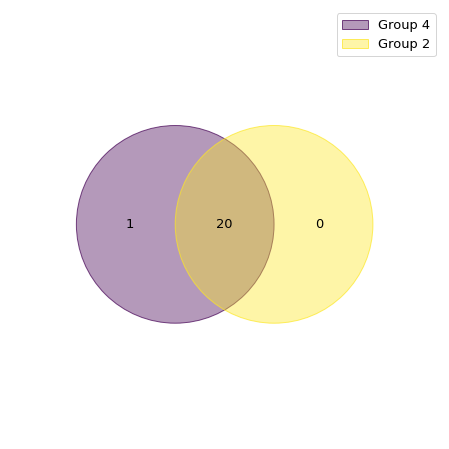

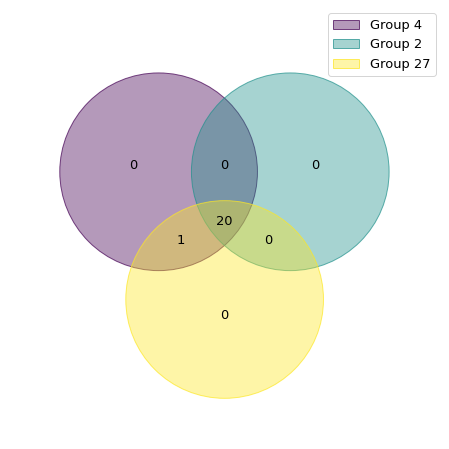

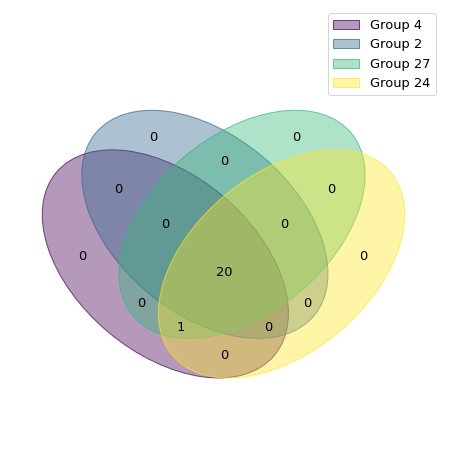

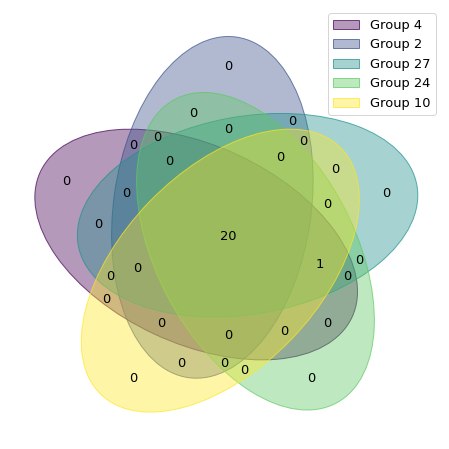

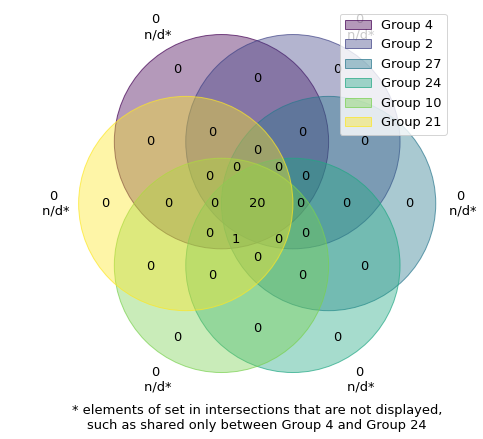

In [32]:

def predict_groups_preferences(users_in_groups, unique_submissions:dict, train_data, group_centers=None, user_grouping_method = "rep", existing_votes = None, existing_user_updown_votes=None):
    # users_in_groups = existing_user_votes.most_common(3)
    groups_users_preferred_submissions = {}
    used_group_centers = []
    if os.path.exists(config["preferred_submissions_venn_figure_dir"]):
        shutil.rmtree(config["preferred_submissions_venn_figure_dir"])
    os.makedirs(config["preferred_submissions_venn_figure_dir"], exist_ok=True)
    for group_x in users_in_groups:
        if (user_grouping_method == "rep") and (len(users_in_groups[group_x]) <= config["group_user_num_lower_thres"] or len(users_in_groups[group_x]) > config["group_user_num_upper_thres"]): # keep middle sized centers
            continue
        if group_centers is not None: # only keep not similar centers
            group_x_center = group_centers[group_x]
            similar_center = False
            for center in used_group_centers:
                if torch.dot(group_x_center, center) > 0:
                    similar_center = True
                    break
            if similar_center:
                continue

        ################ predicting votes of some users and some submissions ##################
        group_x_users_subreddit_submissions_data = convert_group_users_subreddit_submissions_data(users_in_groups[group_x], unique_submissions)
        predicted_group_x_users_submissions_votes = predict_group_users_submissions_votes(model, group_x_users_subreddit_submissions_data)
        group_x_users_preferred_submissions, group_x_preferred_submissions_ranking, group_x_users_submission_votes, group_x_users_confidence, pred_group_x_users_subreddit_submission_vote_score_matrix, pred_group_x_users_subreddit_submission_vote_matrix = get_group_users_preferred_submissions(model, predicted_group_x_users_submissions_votes, users_in_groups[group_x], group_x_users_subreddit_submissions_data, train_data, existing_votes, thres = config["upvote_downvote_ratio_thres"], existing_pred_submission_user_vote_score_matrix = pred_all_submission_user_vote_score_matrix) # can delete existing_pred_submission_user_vote_score_matrix if not available

        ##########################################################################################

        groups_users_preferred_submissions[f"Group {group_x}"] = group_x_users_preferred_submissions
        if user_grouping_method == "single_user_as_group":
            user_train_vote_prompt = f"voted {existing_user_updown_votes[list(users_in_groups[group_x])[0]]} in training data, prediction confidence {list(group_x_users_confidence.values())[0]}, "
        else:
            user_train_vote_prompt = ""
        print_log(config["log_path"], f"Users in group {group_x} {user_train_vote_prompt}prefers {len(group_x_users_preferred_submissions)}/{len(unique_submissions)} submissions (sorted using %upvotes): {group_x_preferred_submissions_ranking[:len(group_x_users_preferred_submissions)]}")
        if len(groups_users_preferred_submissions) > 1 and len(groups_users_preferred_submissions) <=6:
            ax = venn(groups_users_preferred_submissions) if len(groups_users_preferred_submissions) <=5 else pseudovenn(groups_users_preferred_submissions)
            ax.figure.savefig(f"{config['preferred_submissions_venn_figure_dir']}/{len(groups_users_preferred_submissions)}_groups.png")


model = model.to(model.device)
predict_groups_preferences(users_in_groups, subreddit_test_submissions[a_subreddit], train_data, group_centers, user_grouping_method=user_grouping_method, existing_votes=existing_votes, existing_user_updown_votes=existing_user_updown_votes)
